# Image analysis in python <img align="right" src="../Supplementary_data/EY_logo.png" style="margin:0px 50px">


## Before you start

Prior to running this notebook, make sure you are familiar with:

* The Beginners' guide and Getting started notebooks
* Basic Python operations using numpy
* Extracting data from the data cube (this won't be covered here)

A walkthrough of this notebook was recorded [here](https://eyaustralia.sharepoint.com/sites/NextWaveBushfireChallenge/Shared%20Documents/Forms/AllItems.aspx?csf=1&web=1&e=cavJcv&cid=88eae76a%2Dcb2d%2D482f%2Da952%2D44f3936d62f0&RootFolder=%2Fsites%2FNextWaveBushfireChallenge%2FShared%20Documents%2FGeneral%2FVideo%20guides&FolderCTID=0x0120003A0FE8FC60374746A3E056E993281782) as part of a getting started support session.


## Today's Challenge


Today we are going to show how you might go about detecting fire edges in *N-dimensional* satellite image using Python. For this session we will be using an example satellite image *fire_example.jpg*.

Activities:

* (1) Why image analysis?
* (2) How to read and represent an image
* (3) Describing what an image is
* (4) How to 'split' an image into its parts
* (5) Thresholding an image
* (6) Masking an image
* (7) Contouring an image

This notebook can be run locally or on your virtual machine.

## (1) Why image analysis?

* A core skill of geo-spatial analysis
* Hand-drawing fire boundaries is labour intensive and subject to the bias of the drawer
* Computers can process images more quickly and **accurately** than humans
* Allows better allocation of human resources - to fight fires!
* **Fire signature** may be complex and beyond the quick understanding of humans
* If it's more accurate, that can mean better modelling and lives saved

### Installing OpenCV
This notebook uses a python library called *OpenCV* which is imported as *cv2*. This library is not installed in your environment at deployment time so we can install it now using the cell below. Uncomment and then run the cell (you only need to do this once), then you can recomment it for future runs.

The `!` at the start of the line pushes this command to shell. This means rather than executing python code inside this notebook, you're executing an OS command. You could also do this by opening a terminal window from the jupyter directory.

In [1]:
# !pip install opencv-python-headless

### Importing packages

In [2]:
from mpl_toolkits.mplot3d import Axes3D #to plot in 3D
import matplotlib.pyplot as plt         #to plot arrays as images
from matplotlib import colors           #extra colour representations
from matplotlib import cm               #extra colour representations
import numpy as np                      #to manipulate arrays
import cv2                              #to perform more complex manipulations on arrays

%matplotlib inline

## (2) Reading/representing the Image

(600, 800, 3)


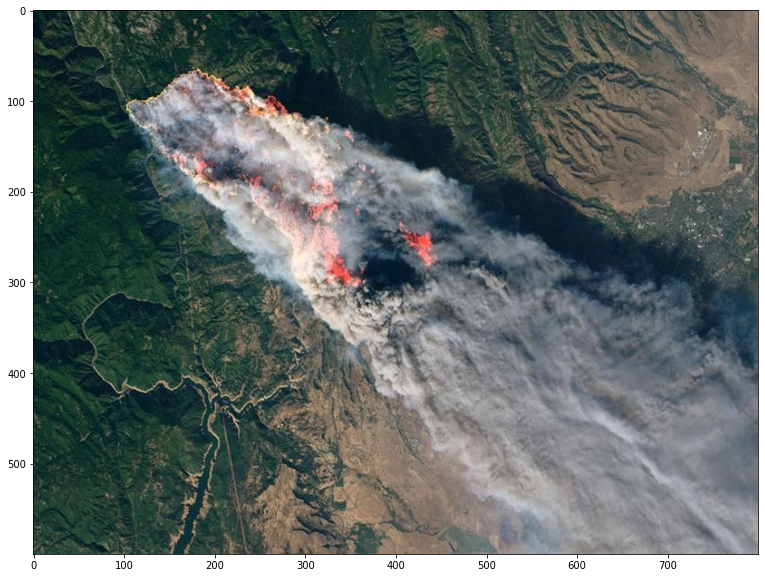

In [3]:
# read image from file. Note: this step will not be necessary 
# for images extracted directly from datacube.
im = cv2.imread('resources/fire_example.jpg')

#show the image size and number of dimensions
print(im.shape)

#invert image from BGR (openCV standard) to RGB (matplotlib representation)
im = im[...,::-1] 
fig = plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

## (3) What is an image to python?

In Python, images are stored as nested *multi-dimensional arrays.* But what does that mean?

Firstly, an *array* can be thought of as just as list (1 dimensional), or table (2 dimensional) of values.

For example, the above image is now stored as an array of **height = 600** and **width = 800**, also known as a 600 x 800 array. Every instance of a row-column pair in this array is called a *pixel*.

At each pixel, Python stores another array describing the contents or colour of that pixel. The length of this array is equivalent to the amount of **dimensions** or **channels** an image has.

For example, standard colour images are recorded using *red, green and blue* channels which are each indicated by a number from 0-255. This is a three-dimensional image. *Grayscale* or *black and white* images are stored with only one value in each pixel. This is a one-dimensional image.

However, some cameras are capable of perceiving more than three light channels and thus will have pixels of *N-dimensions*. Extra light wavelengths might include light not invisible to the human eye known as **ultraviolet** and **infrared**. This is known as multi-spectral imaging, and is available for extraction from your data cube.

Today, we will mostly discuss standard three dimensional image representations. However, the techniques we discuss will be broad enough to apply in more than three dimensions!

In [4]:
#examining the upper left pixel of the image
im[0][0]

array([55, 74, 88], dtype=uint8)

### Grayscale / Panchromatic images

Often, grayscale or panchromatic representations of images are used as a simplification of standard multi-dimensional images. This can have computational benefits and allows us to see the relative colour 'intensity' of each pixel.

An approximation to convert a coloured numpy image to a panchromatic image is to take the sum of each RGB pixel value to make one pixel. This reduces the image's dimensionality to 1.

(600, 800)


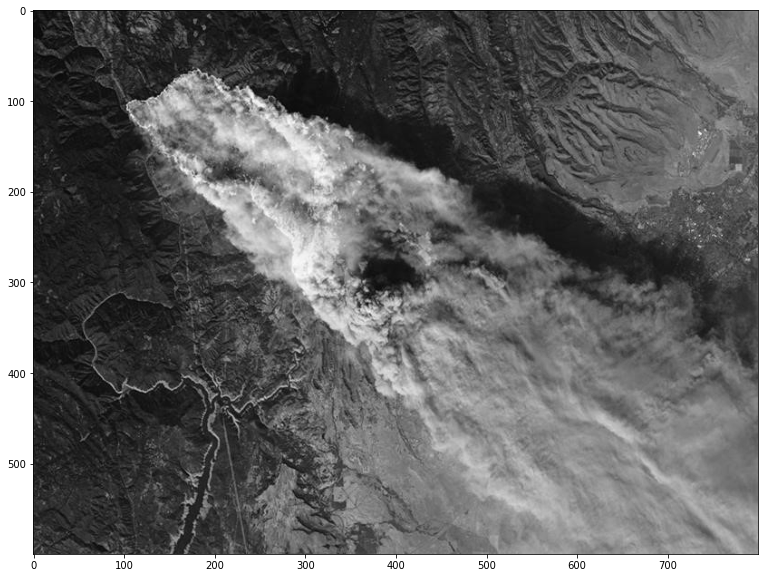

In [5]:
#convert image to gray
im_gray = np.sum(im, axis=2)
print(im_gray.shape) #check size and dimensionality

#plot the image
fig = plt.figure(figsize=(20, 10))
plt.imshow(im_gray,cmap='gray') #specify gray representation
plt.show()

In [6]:
im_gray[0][0]

217

## (4) Decomposing an image

One way that images are commonly analysed is by splitting up each distinct channel or dimension of an image. The purpose of this is to inspect which elements of an image are captured by which channels and it will also allow you to hypothesise metrics or models that might be used to describe these relationships.

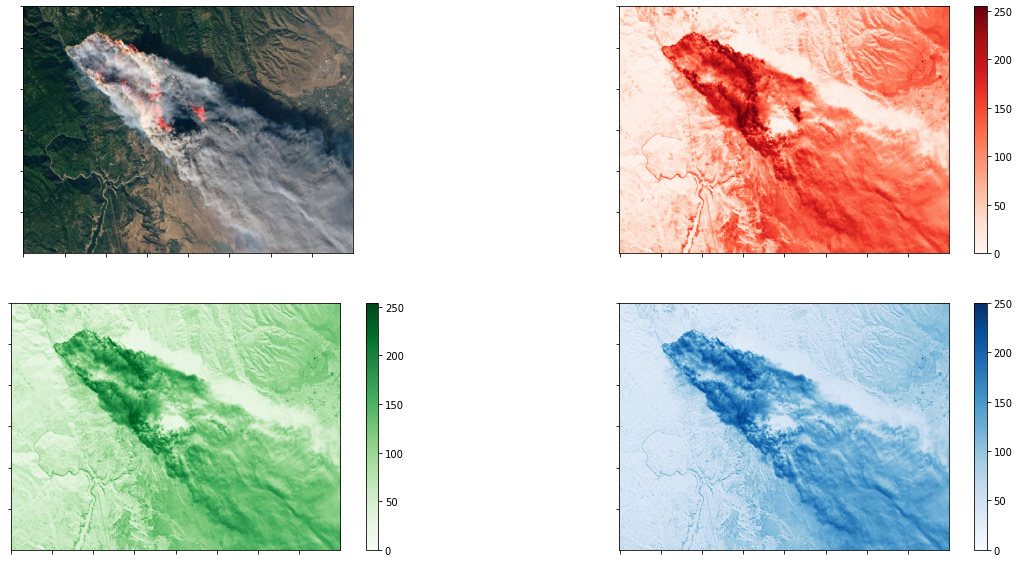

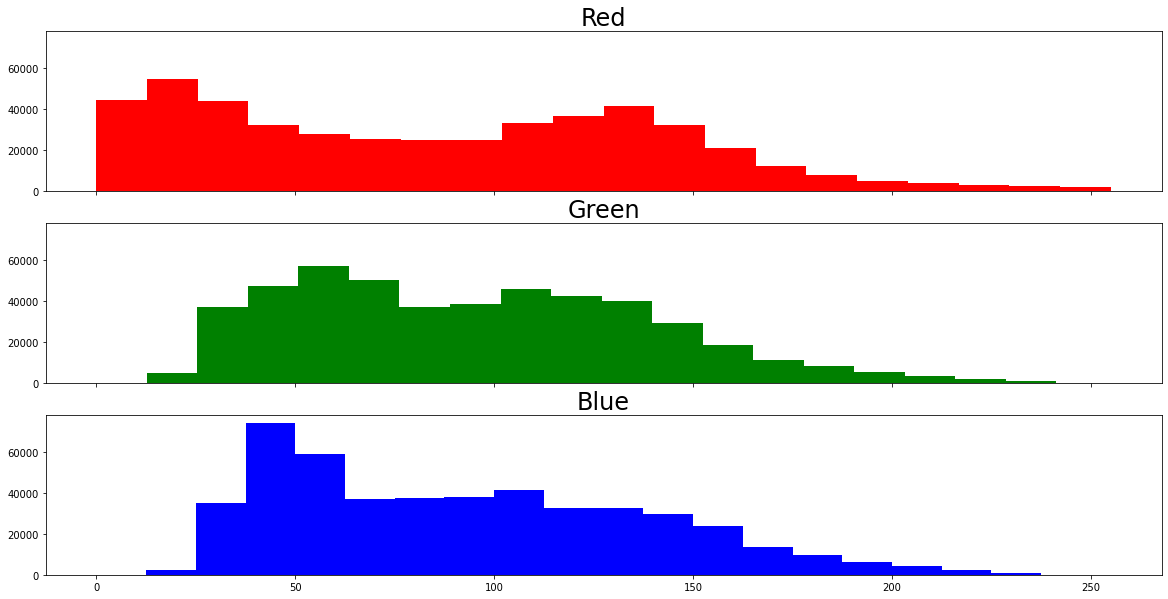

In [7]:
#split the rgb values by indexing
red = im[:, :, 0]
green = im[:, :, 1]
blue = im[:, :, 2]
#infra = im[:, :, 3]

#set up the figure for plotting
fig, axs = plt.subplots(2,2, figsize=(20, 10))

cax_00 = axs[0,0].imshow(im)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

#plot histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(20, 10))

axs[0].hist(red.ravel(), bins=20, color = 'red')
axs[0].set_title('Red',fontsize=24)
axs[1].hist(green.ravel(), bins=20, color = 'green')
axs[1].set_title('Green',fontsize=24)
axs[2].hist(blue.ravel(), bins=20, color = 'blue')
axs[2].set_title('Blue',fontsize=24)

plt.show()

Here, we note that the blue and green wavelengths exhibit similar characteristics whilst the histogram of red pixels shows more concentration in the weak values (0-50).

Interesting, high intensity of all colour bands seems to be indicative of fire presence.

### Visualising pixel values in three dimensions

To enhance inspection, it is common to plot pixel values in multiple dimensions. Note, this would also be a good representation should you choose to run an unsupervised learning algorithm (such as k-means clustering) to find the fire boundary.

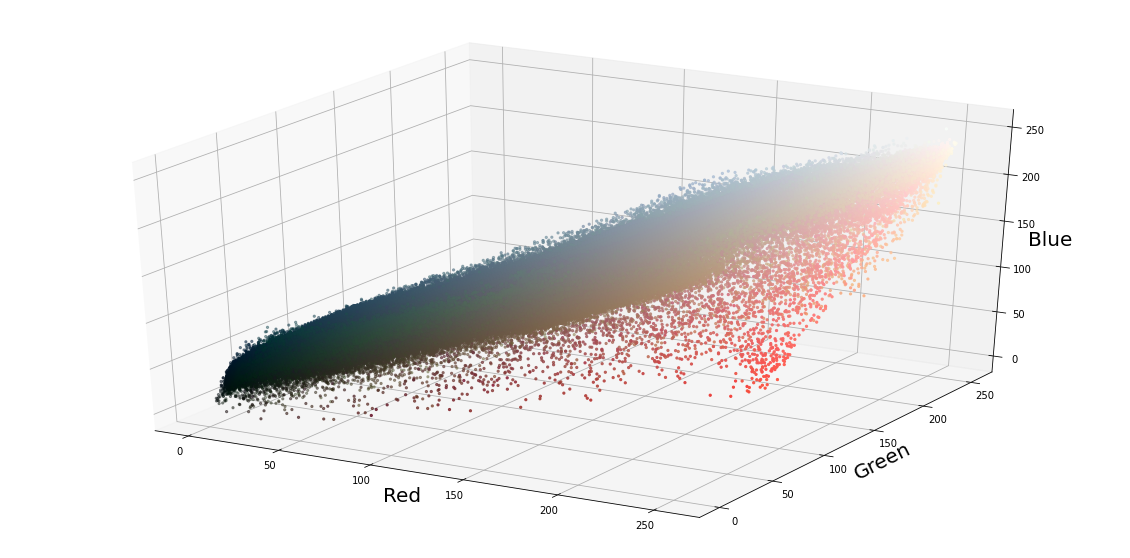

In [8]:
#intialisze plot
fig = plt.figure(figsize=(20, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = im.reshape((np.shape(im)[0]*np.shape(im)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(red.flatten(), green.flatten(), blue.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red",fontsize=20)
axis.set_ylabel("Green",fontsize=20)
axis.set_zlabel("Blue",fontsize=20)
plt.show()

*Does this tell us anything?* Let's try an HSV representation...

### HSV representation of RGB
Another common way to decompose an image is to convert RGB pixels into an HSV representation. Here we are going to do that using OpenCV.

HSV stands for Hue, Saturation, and Value. It is a very common representation in computer vision as it allows users to decompose **intensity** rather than just **colour**.


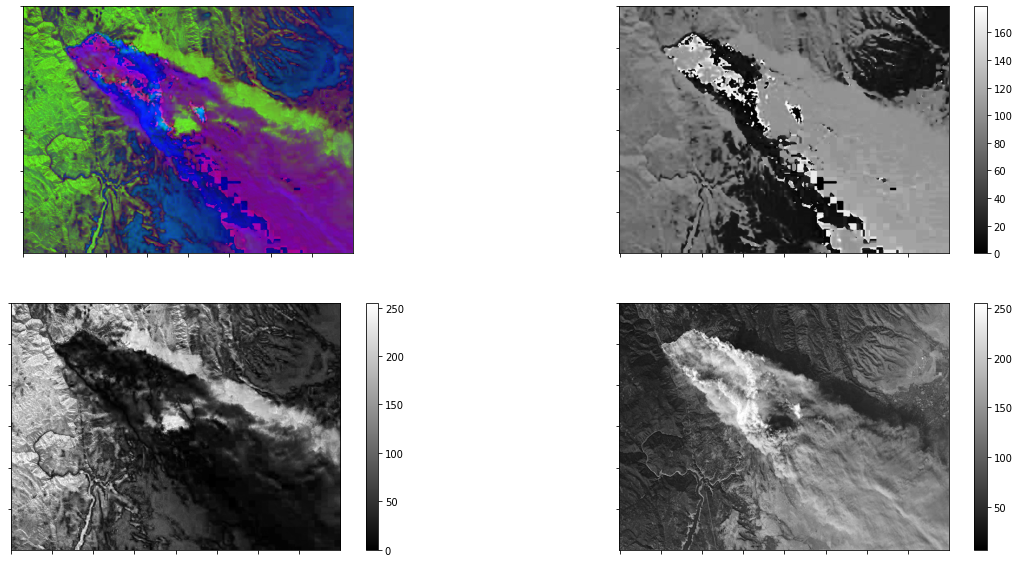

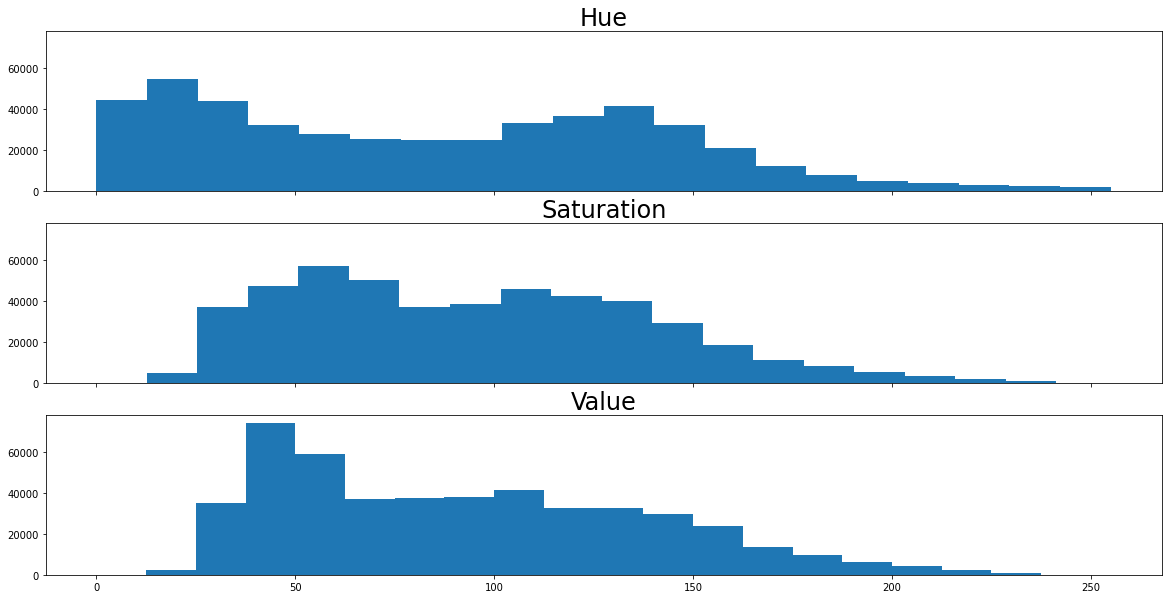

In [9]:
hsv_fire = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
#split into individual components
h, s, v = cv2.split(hsv_fire)

#initialize plot
fig, axs = plt.subplots(2,2, figsize=(20, 10))

cax_00 = axs[0,0].imshow(hsv_fire)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(h, cmap='gray')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(s, cmap='gray')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(v, cmap='gray')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

#plot
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(20, 10))

axs[0].hist(red.ravel(), bins=20)
axs[0].set_title('Hue',fontsize=24)
axs[1].hist(green.ravel(), bins=20)
axs[1].set_title('Saturation',fontsize=24)
axs[2].hist(blue.ravel(), bins=20)
axs[2].set_title('Value',fontsize=24)

plt.show()

Is this a better representation? We can see that the *saturation* and the *value* (or brightness) of the image seem to segment the fire area well, whilst the *hue* value seems to play a role in the detection of smoke.

Maybe we can tell more through another three-dimensional representation:

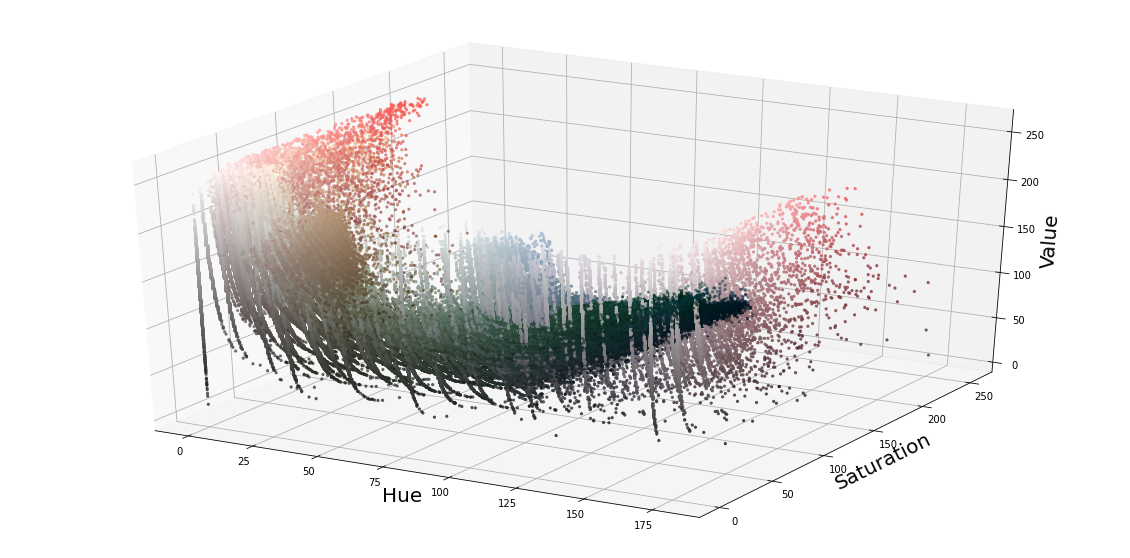

In [10]:
fig = plt.figure(figsize=(20, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue",fontsize=20)
axis.set_ylabel("Saturation",fontsize=20)
axis.set_zlabel("Value",fontsize=20)
plt.show()

Whilst it may be difficult to perceive any relationships here, we can see that there is certainly greater dispersion of pixel values, which may assist us with using an unsupervised learning application.
## (5) Colour masking / thresholding
A colour **mask** isolates a specific colour or range of colour values in an image. It is a nested array of binary integers which we will later multiply with our array of non-binary arrays (the RGB image).

Using our findings above, we can create crude rules to define our colour mask and attempt to isolate regions of the image which contain fire. 

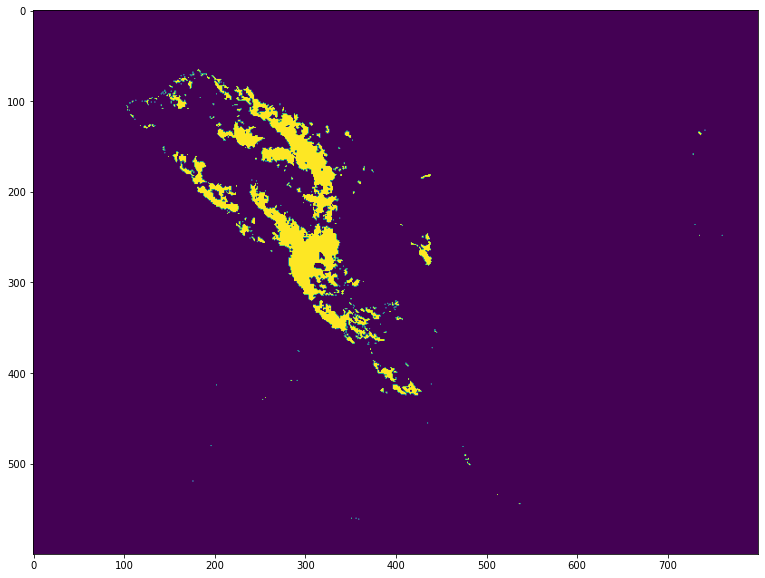

In [11]:
#from our RGB histogram analysis, we define upper and lower pixel values
#give them a try yourself!
lowerBound=np.array([200,100,100]) #R, G, B
upperBound=np.array([255,255,255])

#create the mask over the top of our original image
rgb_mask = cv2.inRange(im,lowerBound,upperBound)

#plot the mask only
fig = plt.figure(figsize=(20, 10))
plt.imshow(rgb_mask)
plt.show()

Note that there is still quite a bit of noise here if our goal is to create a 'smooth' fire boundary. Let's see what we get when we do the same thing to the HSV image.

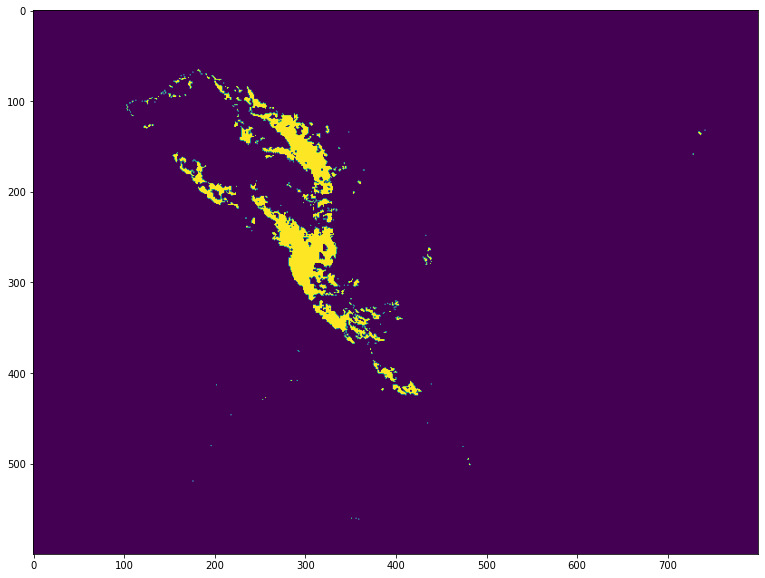

In [12]:
#from our HSV histogram analysis, we define upper and lower pixel values
#give them a try yourself!
lowerBound=np.array([0,0,200]) #H, S, V
upperBound=np.array([50,100,255])

#create the mask over the top of our original image
hsv_mask = cv2.inRange(hsv_fire,lowerBound,upperBound)

#plot the mask only
fig = plt.figure(figsize=(20, 10))
plt.imshow(hsv_mask)
plt.show()

Similar result... Let's go with the RGB mask for the time being.

### Denoising and generalising the mask

You will notice that the mask still contains a lot of noise and thus will not make a 'smooth' fire boundary. Not to matter. We can use a process which dilates and contracts the size of the pixels in the mask to remove noise and join more pixels together.

This will create a smoother fire boundary and will avoid us 'overfitting' our problem. (I.e. coming up with rules that are too specific).

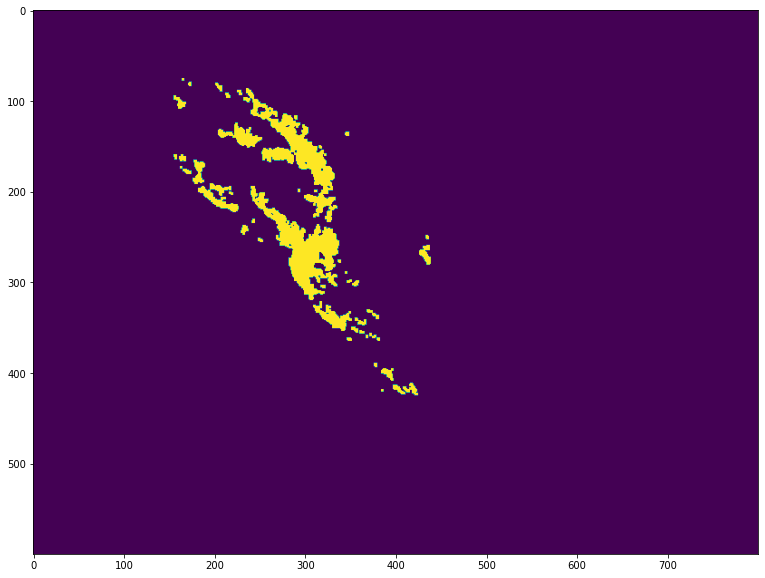

In [13]:
#establish dialation and contraction parameters
kernelOpen=np.ones((3,3)) # try it yourself!
kernelClose=np.ones((64,64))    

#denoise the pixels
maskOpen=cv2.morphologyEx(rgb_mask,cv2.MORPH_OPEN,kernelOpen)

#plot the denoised pixels
fig = plt.figure(figsize=(20, 10))
plt.imshow(maskOpen)
plt.show()

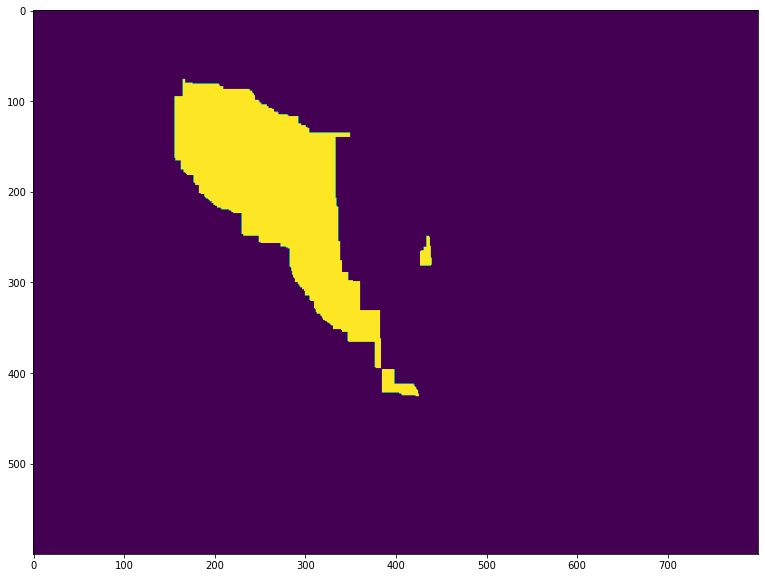

In [14]:
#join the pxels together
maskClose=cv2.morphologyEx(maskOpen,cv2.MORPH_CLOSE,kernelClose)

#plot
fig = plt.figure(figsize=(20, 10))
plt.imshow(maskClose)
plt.show()

Looks good... Ready for submission!

### Applying the mask

Now that we have what looks like a reasonable mask, we need to apply the mask on our original image so we can check how reasonable the mask really is. 

Mathematically, given our mask is a binary array, this action is equivalent to multiplying our mask with our original image.

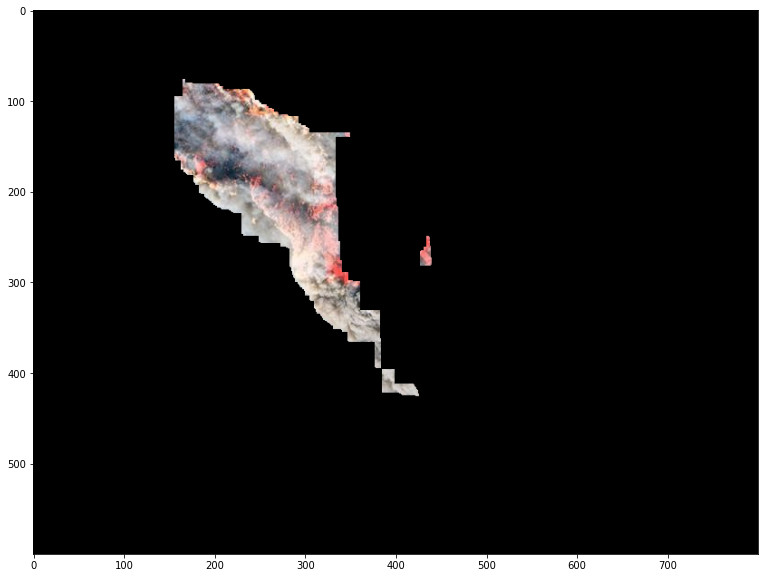

In [15]:
#invoke the cv function to apply mask
result = cv2.bitwise_and(im, im, mask=maskClose)
#result = im * np.expand_dims(maskClose, axis=-1) #can also perform mathmatically

#show result
fig = plt.figure(figsize=(20, 10))
plt.imshow(result)
plt.show()

Not too bad it seems...

## (6) Converting the mask to a boundary
To convert the mask to a fire boundary, we must find the contours, or edges of the mask. Because we denoised and joined the pixels, we should end up with a reasonably simplistic representation of the fire boundary. 

Note that if we had not denoised and joined our mask, our fire boundary would comprise of many separate, disjoined sections. This is likely to 'overfit' our image and will not generalise well to other images.

Mathematically, contour detection can be thought of as isolating pixels where the rate of change in intensity is highest. On a binary mask, this is an easy task.

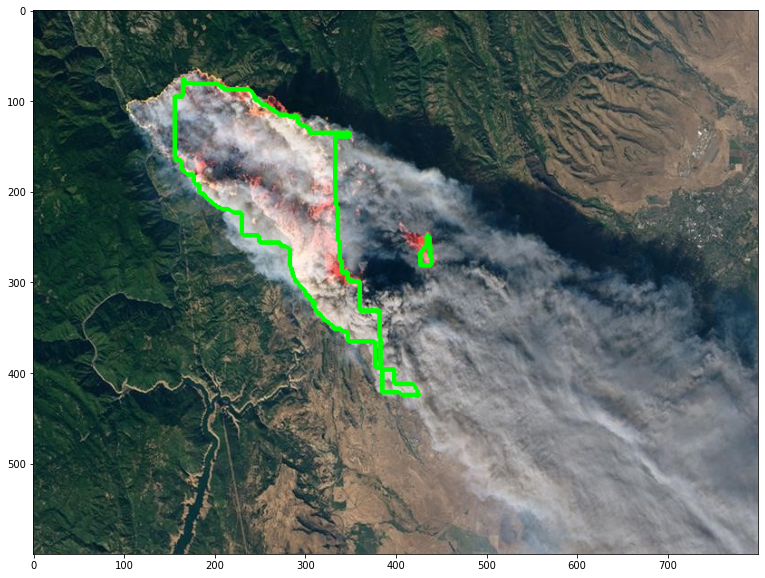

In [16]:
#expand dimensioality of image
final_mask = np.expand_dims(maskClose, axis=-1)

#use opencv to find the contours
contours, hierarchy = cv2.findContours(final_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#overlay our image with the contours
imcont = cv2.drawContours(np.array(im), contours, -1, (0,255,0), 3)

#plot the result!
fig = plt.figure(figsize=(20, 10))
plt.imshow(imcont)
plt.show()

### Next steps
*Can this process be improved by leveraging higher-dimensional images and machine learning?*